In [16]:
#question 4.6: plotting café's and restaurants in 10 minute walk
import requests
import folium

#I need to use the overpass api for these codes
overpass_url = "https://overpass-api.de/api/interpreter"

overpass_query = """
[out:json];
(
  node(around:700, 52.380932, 4.887500); 
  way(around:700, 52.380932, 4.887500);
  rel(around:700, 52.380932, 4.887500);
);
out center;
"""

#sending the query to the Overpass API to get the data
response = requests.get(overpass_url, params={"data": overpass_query})

if response.status_code == 200:
    data = response.json()

    # creating a map on coordinates of finish line
    m = folium.Map(location=[52.380932, 4.887500], zoom_start=15)

    # markers for cafes and restaurants
    cafe_markers = folium.FeatureGroup(name='Cafes')
    restaurant_markers = folium.FeatureGroup(name='Restaurants')

    # blue markers for cafes and green for restaurants. I named cafes "cafes/bars"because they are kind of the same
    for element in data['elements']:
        if 'tags' in element:
            tags = element['tags']
            if 'amenity' in tags:
                amenity = tags['amenity']
                if amenity in ['cafe', 'bar']:
                    location = (element.get('lat'), element.get('lon'))
                    popup = tags.get('name', 'Cafe/Bar')
                    icon_color = 'blue'
                    if None not in location:
                        cafe_markers.add_child(folium.Marker(
                            location=location,
                            popup=popup,
                            icon=folium.Icon(color=icon_color)
                        ))
                elif amenity == 'restaurant':
                    location = (element.get('lat'), element.get('lon'))
                    popup = tags.get('name', 'Restaurant')
                    icon_color = 'green'
                    if None not in location:
                        restaurant_markers.add_child(folium.Marker(
                            location=location,
                            popup=popup,
                            icon=folium.Icon(color=icon_color)
                        ))

    #putting the markers on the map
    m.add_child(cafe_markers)
    m.add_child(restaurant_markers)

    #I added layers as an extra to see where the cafe's and restaurants are
    folium.LayerControl().add_to(m)

 # amount of cafes and restaurants
    print(f"Number of cafes: {cafe_count}")
    print(f"Number of restaurants: {restaurant_count}")
#limit: I don't think the roads are taken into account. so many of these places are further away than 10 minutes but in the range of 700 meters.
m



Number of cafes: 48
Number of restaurants: 134


In [13]:
#question 4.4 (part 1) plotting close public transport station to the finish line

import folium
import overpy

#I will plot the different public transport stations in the area below.
api = overpy.Overpass()
query = """
  node["railway"="tram_stop"](around:700, 52.380932, 4.887500); 
  node["highway"="bus_stop"](around:700, 52.380932, 4.887500); 
  out center;
"""
result = api.query(query)

#creating map of Amsterdam
m = folium.Map(location=[52.379189, 4.899431], zoom_start=15)

# add marker for each station
for node in result.nodes:
    stop_name = node.tags.get('name', 'Unknown')
    lat, lon = node.lat, node.lon
    folium.Marker(location=[lat, lon], popup=stop_name).add_to(m)

m


In [25]:
#question 4.4 (part 2) plotting the closest station to the finish line

import requests
from geopy.distance import geodesic
import folium

# Define the query to search for tram and metro stations with Overpass API
overpass_url = "https://overpass-api.de/api/interpreter"

overpass_query = """
[out:json];
(
  node["railway"="tram_stop"](around:700, 52.380932, 4.887500); 
  node["railway"="subway_entrance"](around:700, 52.380932, 4.887500); 
);
out center;
"""

# Send the query to the Overpass API to get the tram and metro station data
response = requests.get(overpass_url, params={"data": overpass_query})

if response.status_code == 200:
    data = response.json()

    # Finish point coordinates
    finish_point = (52.375073, 4.882201)

    closest_station = None
    closest_distance = float('inf')  # Initialize with a large value

    # Iterate through the station data and find the closest station
    for element in data['elements']:
        if 'lat' in element and 'lon' in element:
            station_location = (element['lat'], element['lon'])
            distance = geodesic(finish_point, station_location).meters

            if distance < closest_distance:
                closest_station = element
                closest_distance = distance

    if closest_station:
        closest_station_name = closest_station.get('tags', {}).get('name', 'Unknown')
        print(f"Closest station: {closest_station_name}")
        print(f"Distance to closest station: {closest_distance} meters")

        # Create a map centered at the finish point
        m = folium.Map(location=finish_point, zoom_start=15)

        # Add a marker for the closest station
        folium.Marker(
            location=station_location,
            popup=closest_station_name,
            icon=folium.Icon(color='red')
        ).add_to(m)
m

#amount of tram and busstops close with the capacity of 185 people in tram and 60 in bus (max capacity so it will be lowered by 15 (tram) and 10(bus) for comfort)
#tram goes 6 times an hour and bus 10. 7080 people can be transported per hour by public transport
y=(4*6*170)+(6*10*50)
print(y)
m


Closest station: Marnixplein
Distance to closest station: 390.6289303269224 meters
7080


In [17]:
#question 4.4 part 3? route of tramline 5 (the only tram that is on marnixplein)
import folium
import overpy

#I need an overpy api for this as well
api = overpy.Overpass()

#Overpass query for relating tram 5 with amsterdam
query = """
  relation["type"="route"]["route"="tram"]["ref"="5"];
  (._; >;);
  out body;
"""

#need to send this result to the query
result = api.query(query)

#making map of amsterdam
m = folium.Map(location=[52.379189, 4.899431], zoom_start=13)

#plotting tramline 5 
for way in result.ways:
    coordinates = [(node.lat, node.lon) for node in way.nodes]
    folium.PolyLine(locations=coordinates, color="blue", weight=3).add_to(m)

m



The centrality of the start point is 0.008907901182222346
The centrality of the middle point is 0.008907901182222346
The centrality of the end point is 0.008907901182222346


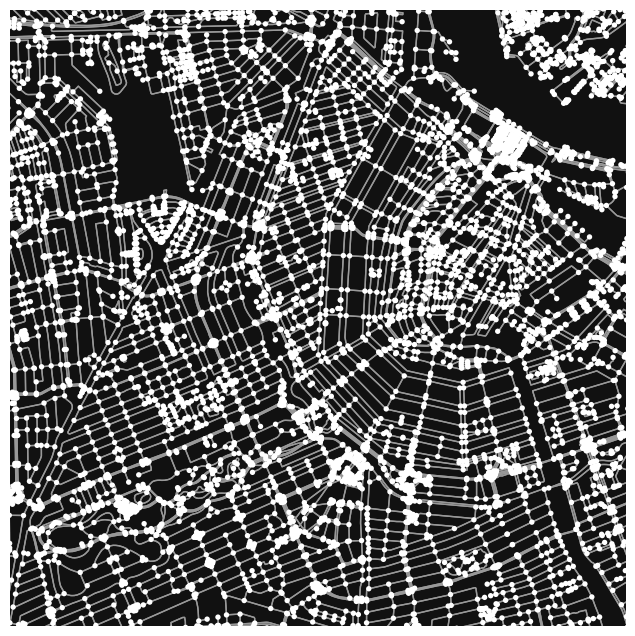

In [21]:
#question 4.5 calculate centrality
import osmnx as ox
import networkx as nx
import folium

#this gets all the data from Amsterdam
walk = ox.graph_from_place('Amsterdam, Netherlands', network_type='walk')

#start, middle, and end coordinates
node_start = (52.380683, 4.888178)
node_middle = (52.368711, 4.882149)
node_finish = (52.380583, 4.888138)

#Plot graph
bbox = ox.utils_geo.bbox_from_point(node_middle, dist=2000)
fig, ax = ox.plot_graph(walk, bbox=bbox, show=False, close=False)
ax.scatter(node_middle[0], node_middle[1], c='red') 

#calculate centrality
nodes_start = ox.distance.nearest_nodes(walk, node_start[0], node_start[1], return_dist=True)
nodes_middle = ox.distance.nearest_nodes(walk, node_middle[0], node_middle[1], return_dist=True)
nodes_finish = ox.distance.nearest_nodes(walk, node_finish[0], node_finish[1], return_dist=True)

start_centrality = nx.closeness_centrality(walk, u=nodes_start[0])
middle_centrality = nx.closeness_centrality(walk, u=nodes_middle[0])
end_centrality = nx.closeness_centrality(walk, u=nodes_finish[0])

#Folium map
map_center = (node_middle[0], node_middle[1])
m = folium.Map(location=map_center, zoom_start=15)

#markers for the start, middle, and end nodes with centrality values
folium.Marker(node_start, icon=folium.Icon(color='blue'), popup=f'Start Centrality: {start_centrality}').add_to(m)
folium.Marker(node_middle, icon=folium.Icon(color='red'), popup=f'Middle Centrality: {middle_centrality}').add_to(m)
folium.Marker(node_finish, icon=folium.Icon(color='green'), popup=f'End Centrality: {end_centrality}').add_to(m)

#print
print('The centrality of the start point is', start_centrality)
print('The centrality of the middle point is', middle_centrality)
print('The centrality of the end point is', end_centrality)
m